In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dautils

### Read dataframe

In [2]:
# read dataset
df = pd.read_csv('../data/adult_continuous.csv', na_values='?')
# remove unused columns
del df['fnlwgt']
del df['education-num']
# remove special characters in column names and values
df.columns = df.columns.str.replace("[-&]", "")
df = df.replace('[-&]', '', regex=True)
df.info()

C:\Users\ruggieri\AppData\Local\Temp\ipykernel_15292\1641756020.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace("[-&]", "")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            48842 non-null  int64 
 1   workclass      46043 non-null  object
 2   education      48842 non-null  object
 3   maritalstatus  48842 non-null  object
 4   occupation     46033 non-null  object
 5   relationship   48842 non-null  object
 6   race           48842 non-null  object
 7   sex            48842 non-null  object
 8   capitalgain    48842 non-null  int64 
 9   capitalloss    48842 non-null  int64 
 10  hoursperweek   48842 non-null  int64 
 11  nativecountry  47985 non-null  object
 12  class          48842 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.8+ MB


In [3]:
# missing values imputation (for Decision Trees)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [4]:
# nominal-ordinal-continuous partition of predictive attributes
nominal_atts = ['workclass', 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'nativecountry']
ordinal_atts = ['education']
continuous_atts = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
# class attribute
target = 'class'
# predictive and all atts
pred_atts = nominal_atts + ordinal_atts + continuous_atts
all_atts = pred_atts + [target]

In [5]:
# forcing encoding of ordinal attributes (consistent with the order) and class attribute (0=negatives, 1=positives)
decode = {
    'education': {
        1:'Preschool', 2:'1st4th', 3:'5th6th', 4:'7th8th', 5:'9th', 6:'10th', 7:'11th',
        8:'12th', 9:'HSgrad', 10:'Somecollege', 11:'Assocvoc', 12:'Assocacdm', 13:'Bachelors', 
        14:'Masters', 15:'Profschool', 16:'Doctorate' 
    },
    'class': {
        0: '<=50K', 1: '>50K'
    }
}
# encode nominal (as categories), ordinal+target (as int), passing the encoding of ordinal+target
df_code = dautils.Encode(nominal=nominal_atts, ordinal=ordinal_atts+[target], decode=decode, onehot=True, prefix_sep="_")
df_encoded_onehot = df_code.fit_transform(df)
df_encoded_onehot.head()

,age,workclass_Federalgov,workclass_Localgov,workclass_Neverworked,workclass_Private,workclass_Selfempinc,workclass_Selfempnotinc,workclass_Stategov,workclass_Withoutpay,education,...,nativecountry_PuertoRico,nativecountry_Scotland,nativecountry_South,nativecountry_Taiwan,nativecountry_Thailand,nativecountry_TrinadadTobago,nativecountry_UnitedStates,nativecountry_Vietnam,nativecountry_Yugoslavia,class
0,39,0,0,0,0,0,0,1,0,13,...,0,0,0,0,0,0,1,0,0,0
1,50,0,0,0,0,0,1,0,0,13,...,0,0,0,0,0,0,1,0,0,0
2,38,0,0,0,1,0,0,0,0,9,...,0,0,0,0,0,0,1,0,0,0
3,53,0,0,0,1,0,0,0,0,7,...,0,0,0,0,0,0,1,0,0,0
4,28,0,0,0,1,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# encoded atts names
encoded_pred_atts = df_code.encoded_atts(pred_atts)
# train a decision tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(df_encoded_onehot[encoded_pred_atts], df_encoded_onehot[target])

DecisionTreeClassifier(max_depth=3)

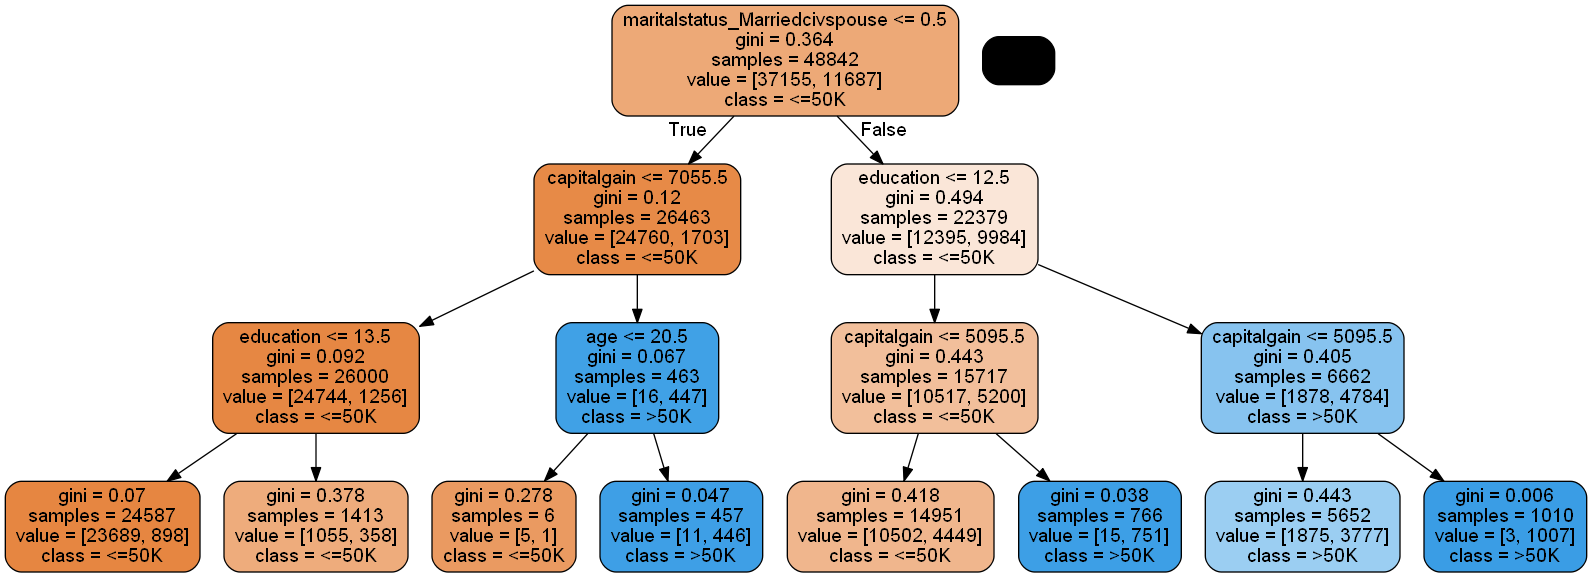

In [7]:
# visualize the decision tree
from sklearn import tree
from IPython.display import Image
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=encoded_pred_atts, # attributes names
                                class_names=df_code.decode[target], # class labels
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Decision tree paths to CLP rules 

In [8]:
from sklearn.tree import _tree

class Model2CLP:
    def __init__(self, pred_atts, target, df_code):
        self.pred_atts = pred_atts
        self.target = target
        self.df_code = df_code
        self.feature_names = df_code.encoded_atts(pred_atts)
        self.constraints = []
        self.instances = dict()

    def tree_to_code(self, tree):
        tree_ = tree.tree_
        classes_ = tree.classes_
        feature_pos = {f:i for i, f in enumerate(self.feature_names)}
        feature_name = [
            feature_pos[self.feature_names[i]] if i != _tree.TREE_UNDEFINED else "undefined!"
            for i in tree_.feature
        ]
        nf = len(self.feature_names)
        print(":- use_module(library(clpr)).")
        print(":- use_module(library(lists)).")
        print("% feature(i, constant) :- constant name for the i-th variable")
        for i, f in enumerate(self.feature_names):
            print('feature({}, {}).'.format(i, f.lower()))
        print('nfeatures({}).'.format(nf))
        print("% path(Vars, Constraint, Pred, Conf) :- Constraint in a path of a decision tree over Vars with prediction Pred and confidence Conf")
        def recurse(node, depth, body="", varset=set()):
            indent = "  " * depth
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                var = feature_name[node]
                name = 'X' + str(var)
                threshold = tree_.threshold[node]
                if body != '':
                    body = body + ','
                body_left = body + "{} =< {}".format(name, threshold)
                varset = varset | set([var])
                recurse(tree_.children_left[node], depth + 1, body_left, varset)
                body_right = body + "{} > {}".format(name, threshold)
                recurse(tree_.children_right[node], depth + 1, body_right, varset)
            else:
                freqs = tree_.value[node][0]
                pred, maxfreq = dautils.argmax(freqs)
                maxfreq /= sum(freqs)
                allf = ','.join( ('X'+str(i) if i in varset else '_') for i in range(nf) )
                print("path([{}], [{}], {}, {}).".format(allf, body, classes_[pred], maxfreq))
                # print("path([{}], {}, {}) :- {{{}}}.".format(allf, classes_[pred], maxfreq, body))
        recurse(0, 1)
    
    def instance(self, name, label):
        if name in self.instances:
            raise "instance "+name+" exists already"
        n = len(self.instances)
        self.instances[name] = (n, label)
        print("instance({}, {}).".format(n, name))
        
    def reset(self):
        self.constraints = []
        self.instances = dict()
        
    def assertc(self, constraint):
        # linear expression on continuous/ordinal features
        self.constraints.append(constraint)
        
    def assertd(self, constraint):
        # equality or membership constraints on nominal features
        # TBD: distinguish between onehot encoded or not
        if self.df_code.onehot:
            pos = constraint.find("<=>")
            if pos >= 0:
                x = constraint[:pos].strip()
                x = x.replace("=", "_")
                y = constraint[pos+3:].strip()
                y = y.replace("=", "_")
                con = x+" = "+y
            else:
                pos = constraint.find("=")
                if pos >= 0:
                    x = constraint[:pos].strip()
                    pos2 = x.find("_")
                    if pos2 < 0:
                        raise "not a var name " + x
                    varx = x[pos2+1:]
                    y = constraint[pos+1:].strip()
                    pos2 = y.find("_")
                    if pos2 >= 0 and y[pos2+1:] in self.df_code.nominal:
                        # equality var1 = var2 
                        con = ", ".join(x+"_"+v.lower()+" = "+y+"_"+v.lower() for v in self.df_code.encode[varx].keys())
                    else:
                        # equality var1 = const
                        con = x+"_"+y.lower()+"=1"
                else:
                    # IN operator to be implemented
                    raise "operator not known or implemented"
        else:
            # non-onehot to be implemented
            raise "non-onehot is not implemented"
        self.constraints.append(con)
        
    def test_clause(self):
        Cs = ", ".join(c for c in self.constraints)
        Vars = ", ".join("X_"+v for v in self.instances.keys())
        CCs = ", ".join("C_"+v for v in self.instances.keys())
        Labs = ", ".join(str(label) for _, (_, label) in self.instances.items())
        
        Paths = ", ".join("path(X_"+v+", C_"+v+", "+str(label)+", _)" for v, (_, label) in self.instances.items())
        print("""\ntest(Vars) :- 
            nfeatures(N), 
            length(Vars, {}),
            lengths(Vars, N),
            paths(Vars, [{}], CCs),
            tells_cs(CCs),
            exp2cons([{}], Vars, Cs),
            tell_cs(Cs).""".format(len(self.instances), Labs, Cs))
        
    def closing(self):
        print("\n:- ['post.pl'].")

In [9]:
m2clp = Model2CLP(pred_atts, target, df_code)
m2clp.tree_to_code(clf)
m2clp.instance('f', 0) # factual
m2clp.instance('cf', 1) # one counter-factual
m2clp.assertc("cf_age >= f_age") # or any other linear expression on continuous/ordinal features
m2clp.assertc("cf_capitalgain >= 2*cf_capitalloss + 20") # or any other linear expression on continuous/ordinal features
m2clp.assertd("cf_race = f_race") # equality on nominal features
m2clp.assertd("cf_sex = male") # equality on nominal features
m2clp.assertd("cf_nativecountry=unitedstates <=> f_nativecountry=france") # iff on nominal features counterfactual from US iff factual from France
#m2clp.assert("distance(f, cf, l1) < 0.2")
#m2clp.assert("sparsity(f, cf, l1) < 0.2")
#m2clp.assertd("raceCF IN (black, amerindianeskimo)") # IN operator on nominal features
m2clp.test_clause()
m2clp.closing()

:- use_module(library(clpr)).
:- use_module(library(lists)).
% feature(i, constant) :- constant name for the i-th variable
feature(0, workclass_federalgov).
feature(1, workclass_localgov).
feature(2, workclass_neverworked).
feature(3, workclass_private).
feature(4, workclass_selfempinc).
feature(5, workclass_selfempnotinc).
feature(6, workclass_stategov).
feature(7, workclass_withoutpay).
feature(8, maritalstatus_divorced).
feature(9, maritalstatus_marriedafspouse).
feature(10, maritalstatus_marriedcivspouse).
feature(11, maritalstatus_marriedspouseabsent).
feature(12, maritalstatus_nevermarried).
feature(13, maritalstatus_separated).
feature(14, maritalstatus_widowed).
feature(15, occupation_admclerical).
feature(16, occupation_armedforces).
feature(17, occupation_craftrepair).
feature(18, occupation_execmanagerial).
feature(19, occupation_farmingfishing).
feature(20, occupation_handlerscleaners).
feature(21, occupation_machineopinspct).
feature(22, occupation_otherservice).
feature(2